   The initial purpose of the program, was to only plot various coins diagrams, together with various market indicators.
Indicators values could then assume for us, whether the coin's price is going to grow, or fall. 
    During the development, I have come up with an idea for creating a Recurrent Neural Network (LSTM - Long Short Term Memory Network) model which predicts the movement of the crypto coin markets.
So far, the model is very simple, it only takes the historical coin prices into consideration. In the future, I want to implement the possibility, to take the market indicators into consideration - like Volume, RSI, MACD and others.

The data is imported from currently the biggest Crypto Exchange - Binance. 
If you want to do the imports by yourself, you need a Binance account and an API key that is bound to it.
You can get one here - [LINK](https://www.binance.com/?ref=10815185)
You should put your API key's into config.py file.

To keep the data in a SQL table, I have chosen the PostgreSQL. Once you setup a server, you should put all the info about it and its database into a database.ini file.
You can read about postgresql on it's official site - [LINK](https://www.postgresql.org/)

Below an example plot for one of the coins, together with the Ichimoku Cloud and other indicators, which are very useful when predicting future crypto markets.

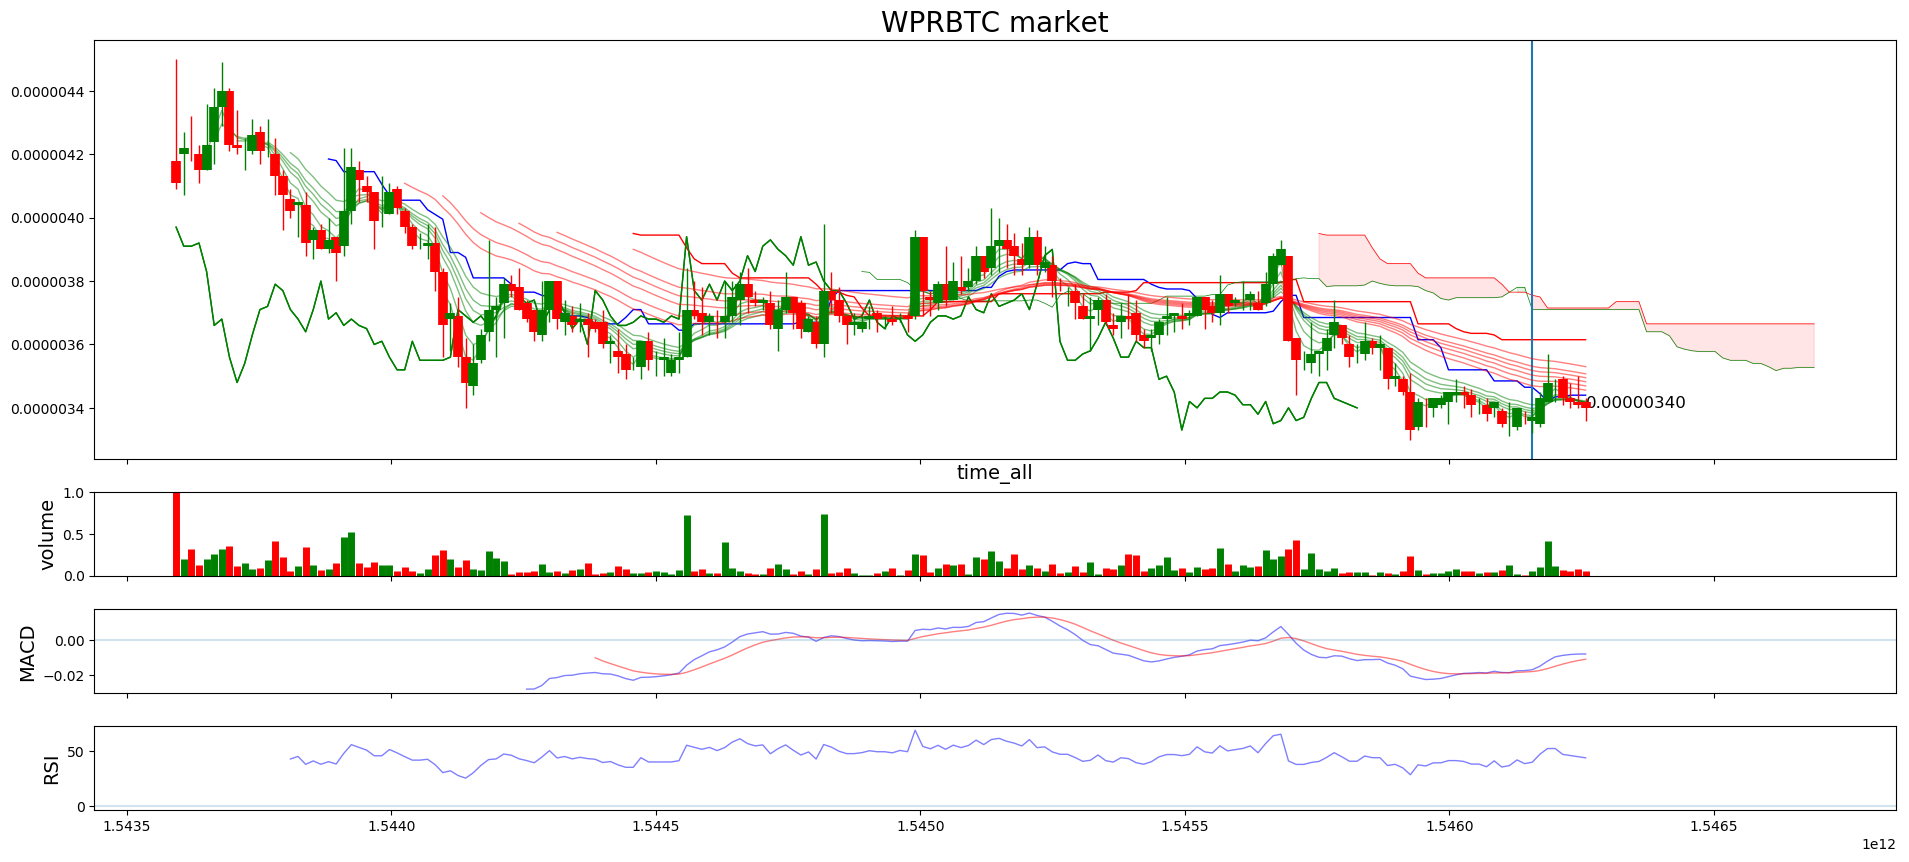

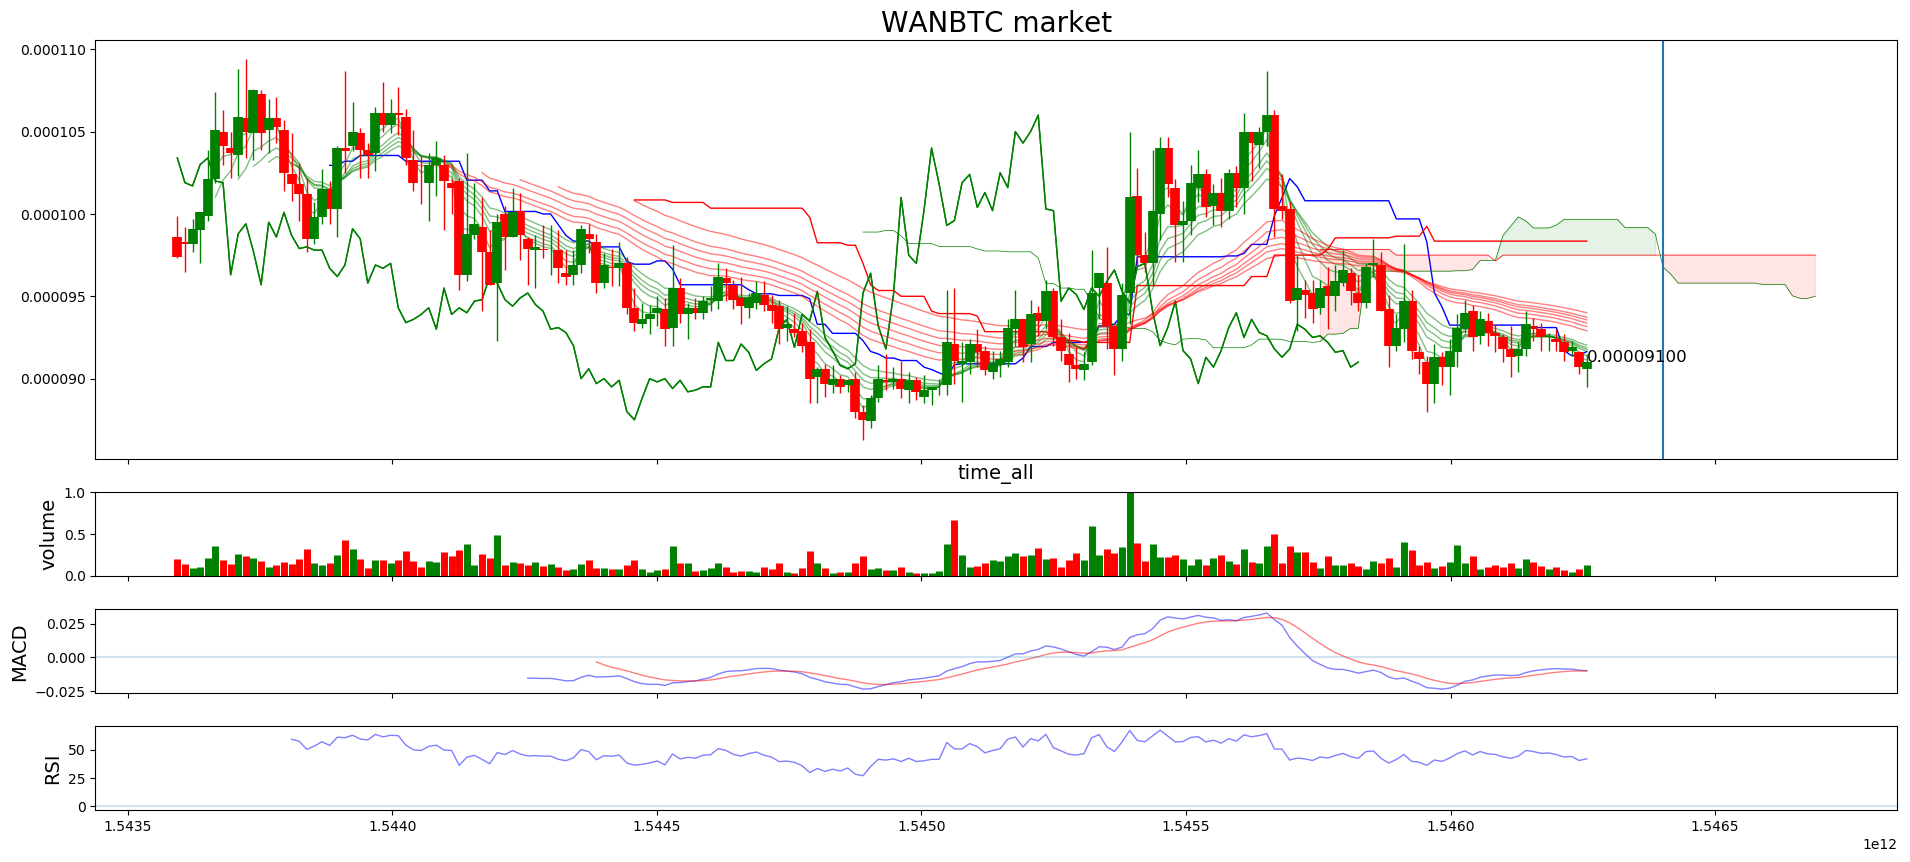

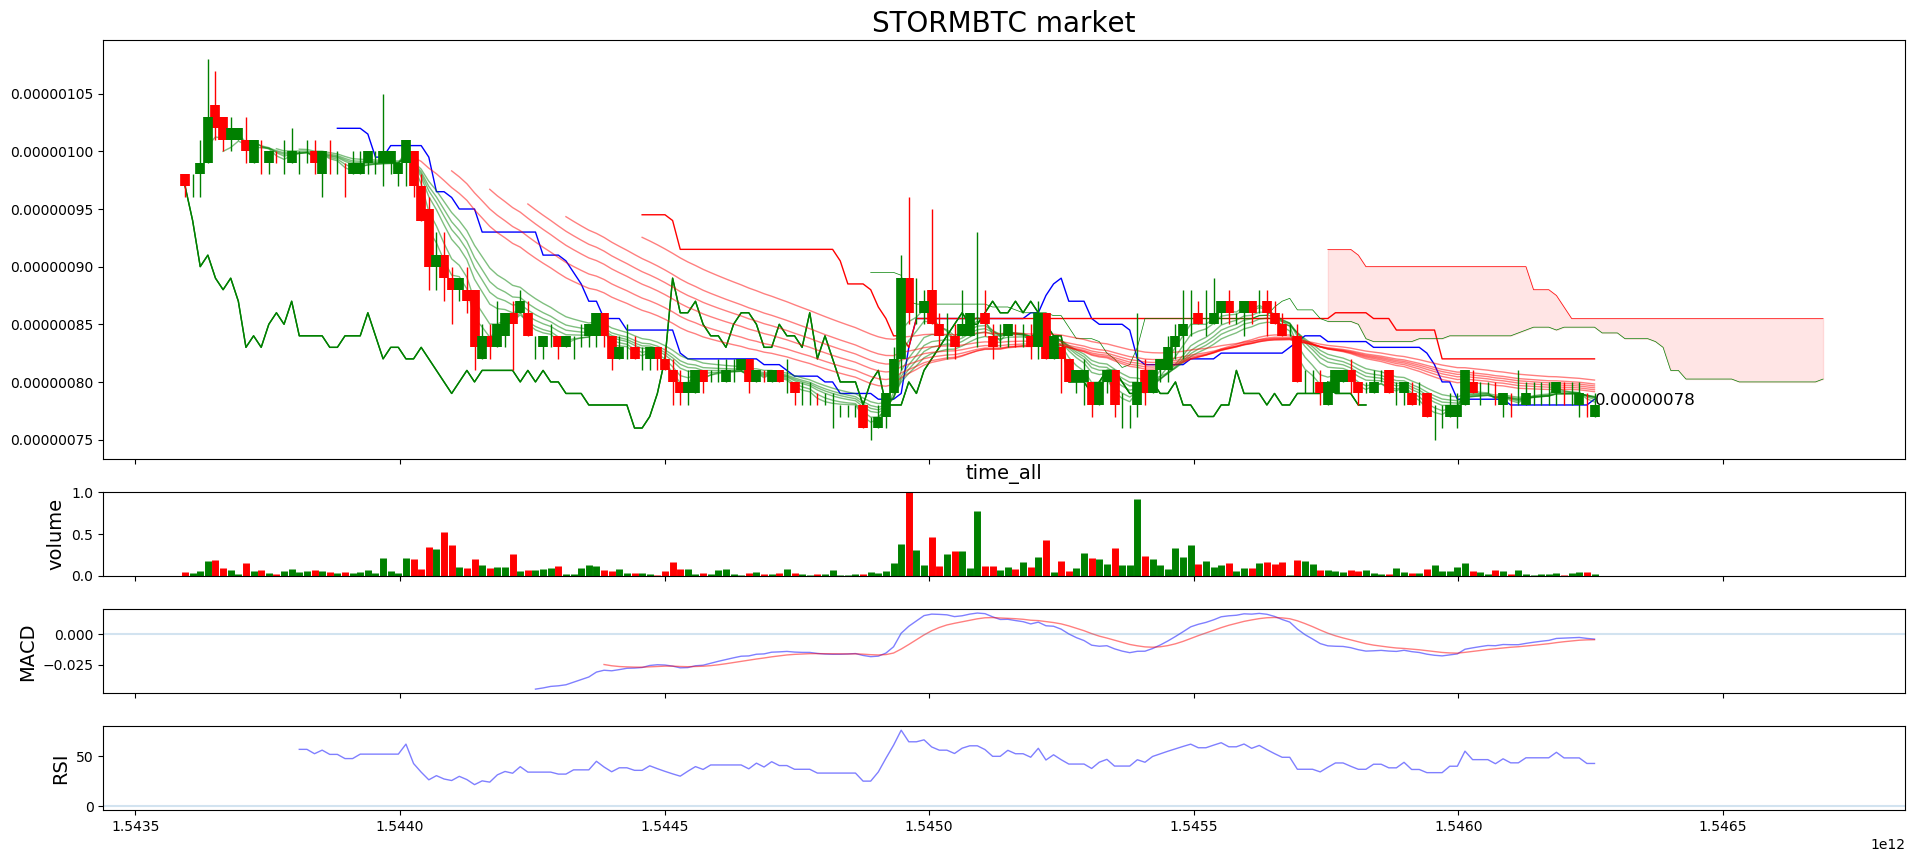

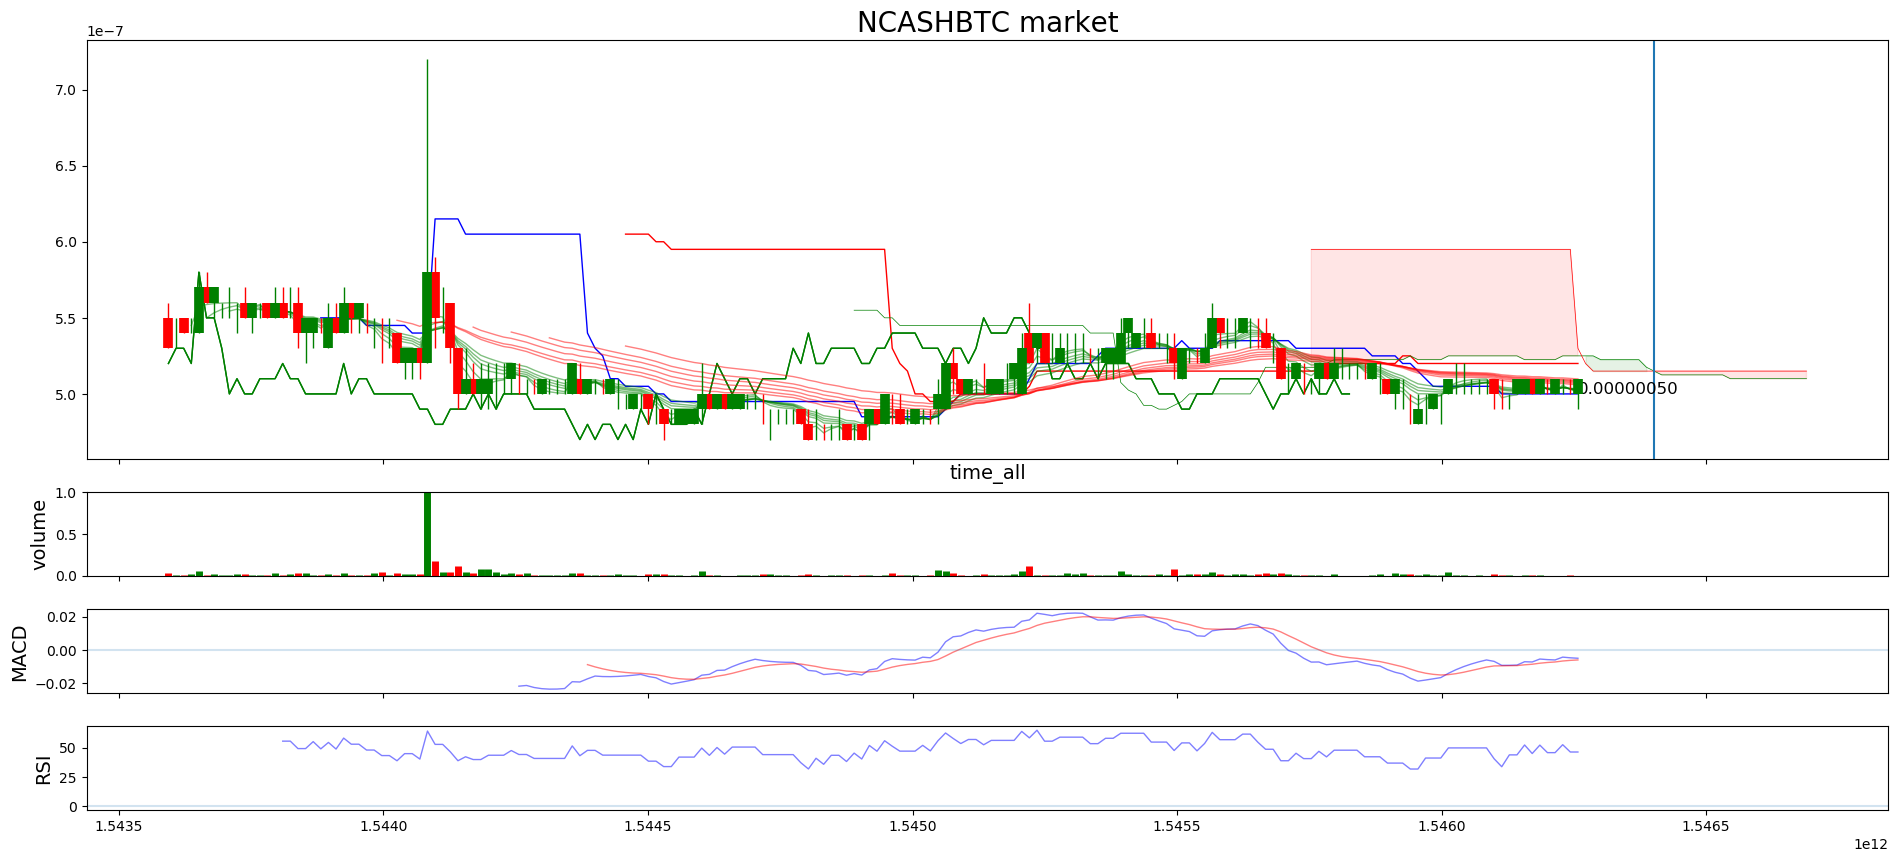

In [1]:
from IPython.core.display import Image, display
display(Image('WPRBTC_4H.png', width=1800, unconfined=True))
display(Image('WANBTC_4H.png', width=1800, unconfined=True))
display(Image('STORMBTC_4H.png', width=1800, unconfined=True))
display(Image('NCASHBTC_4H.png', width=1800, unconfined=True))

Part below regards the RNN LSTM model only. Everything else is put as code into other *.py files.

In [2]:
import psycopg2
from config import config
import numpy as np
import pandas as pd

/home/radek/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# set the SQL params
params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()

Because crypto is a fairly new market, I have chosen a 1Hour TimeFrame, in order to get a lot of data.
Binance is a relatively new exchange (August 2017') - if I chose a 1Day TimeFrame, I would only get less than 500 entries.
The model I would create based on that small amount of data would not be satisfactory in any way.

Choosing 1H TF enabled me to get over 10000 entries.

In [4]:
# import data from SQL table - depending on the coin its time frame, datatable name will differ.
data = pd.read_sql('SELECT * FROM btcusdt_1h', conn)

# TODO - uncomment if you want to use a csv file instead
# import data from CSV table
# csv_path = 'path_to_csv'
# data = pd.read_csv(csv_path)

In [5]:
data = data.sort_values('open_time')
data.head()

,id,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote,no_trades,...,ema200,short_gmma,long_gmma,d_gmmas,senkou_a,senkou_b,d_senkou,macd,rsi,local_cloud
0,1,2017-08-25 14:00:00,4361.27,4361.27,4261.13,4309.69,110.998609,2017-08-25 14:59:00,479266.243589,1891,...,4133.335622,19.107417,62.930351,158.954923,4233.8675,3885.840,348.0275,0.913204,54.577419,0.288670
1,2,2017-08-25 15:00:00,4311.69,4345.00,4297.66,4312.00,20.801018,2017-08-25 15:59:00,89785.160922,188,...,4135.113377,13.548506,62.295333,162.494094,4239.2250,3885.840,353.3850,0.866177,54.852246,0.288739
2,3,2017-08-25 16:00:00,4303.82,4340.00,4291.52,4305.00,10.610266,2017-08-25 16:59:00,45804.268023,139,...,4136.803791,9.648153,61.366884,165.687719,4239.4750,3885.840,353.6350,0.817427,53.790156,0.285164
3,4,2017-08-25 17:00:00,4321.50,4422.29,4321.50,4394.36,21.796763,2017-08-25 17:59:00,95349.335161,189,...,4139.366539,34.283864,63.232328,171.706471,4242.9625,3885.840,357.1225,0.937330,63.504895,0.283014
4,5,2017-08-25 18:00:00,4394.36,4453.91,4375.29,4447.31,17.784780,2017-08-25 18:59:00,78475.084397,179,...,4142.430653,65.286687,66.466515,179.263952,4268.2675,3911.145,357.1225,1.094702,67.821742,0.283679


The SQL table is constructed to keep all of the indicators - these will be implemented in the RNN model in the future.

There are also some unnecessary columns that got imported from Binance exchange. These will not be useful for us. We will get rid of those right away.

In [6]:
data.drop(labels=['id', 'close_time', 'ignore_val', 'taker_quote'], inplace=True, axis=1)

The time we import from binance is in a timestamp form. 

I have written these two functions that allow us to change the timestamp into a UTC time format (or the other way around).

In [7]:
import time
from datetime import datetime, timezone

def to_timestamp(dt):
    timestamp = dt.replace(tzinfo=timezone.utc).timestamp()
    return timestamp

def time_from_ts(timestamp, timespec='minutes'):
    st = datetime.fromtimestamp(timestamp / 1000)
    time_transformed = str(st.isoformat(timespec=timespec, sep=' '))
    return time_transformed

For now, we will only be needing the coin price and we calculate it by the median of 'high_price' and 'low_price'.

In [8]:
data['mid_price'] = (data.high_price + data.low_price) / 2

In [9]:
data.head()

,open_time,open_price,high_price,low_price,close_price,volume,quote,no_trades,taker_base,ema12,...,short_gmma,long_gmma,d_gmmas,senkou_a,senkou_b,d_senkou,macd,rsi,local_cloud,mid_price
0,2017-08-25 14:00:00,4361.27,4361.27,4261.13,4309.69,110.998609,479266.243589,1891,7.918988,4315.897177,...,19.107417,62.930351,158.954923,4233.8675,3885.840,348.0275,0.913204,54.577419,0.288670,4311.200
1,2017-08-25 15:00:00,4311.69,4345.00,4297.66,4312.00,20.801018,89785.160922,188,4.482264,4315.297611,...,13.548506,62.295333,162.494094,4239.2250,3885.840,353.3850,0.866177,54.852246,0.288739,4321.330
2,2017-08-25 16:00:00,4303.82,4340.00,4291.52,4305.00,10.610266,45804.268023,139,6.107378,4313.713363,...,9.648153,61.366884,165.687719,4239.4750,3885.840,353.6350,0.817427,53.790156,0.285164,4315.760
3,2017-08-25 17:00:00,4321.50,4422.29,4321.50,4394.36,21.796763,95349.335161,189,5.421801,4326.120538,...,34.283864,63.232328,171.706471,4242.9625,3885.840,357.1225,0.937330,63.504895,0.283014,4371.895
4,2017-08-25 18:00:00,4394.36,4453.91,4375.29,4447.31,17.784780,78475.084397,179,3.762923,4344.765071,...,65.286687,66.466515,179.263952,4268.2675,3911.145,357.1225,1.094702,67.821742,0.283679,4414.600


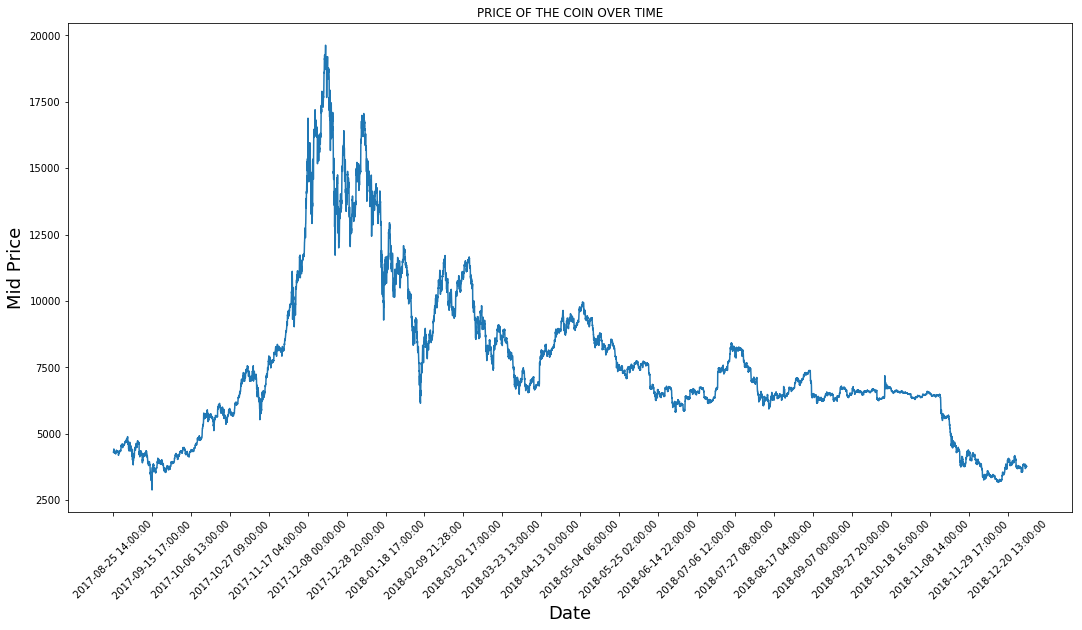

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),data['mid_price'])
plt.xticks(range(0,data.shape[0],500),data['open_time'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.title('PRICE OF THE COIN OVER TIME')
plt.show()

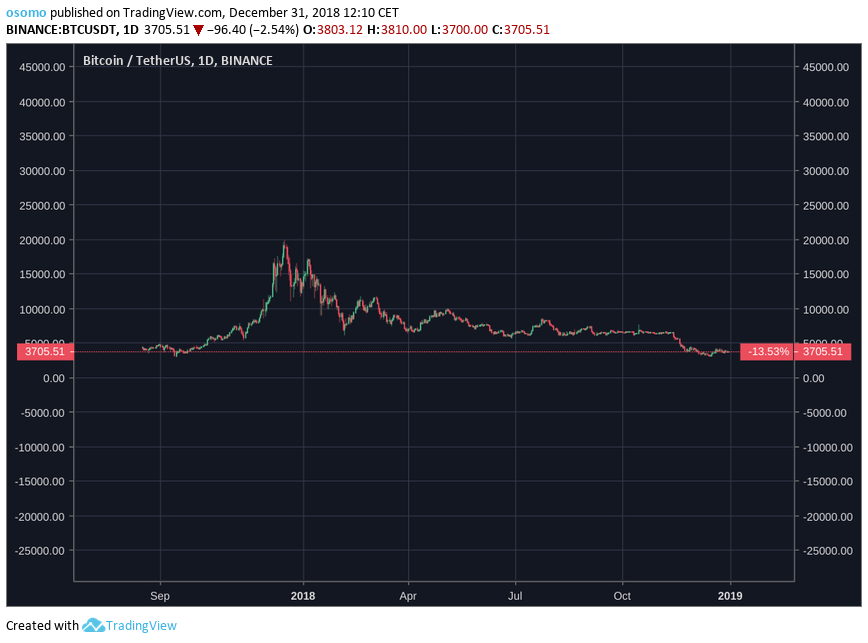

In [11]:
# Just to confirm, a screenshot from tradingview to confirm the data is correct.
display(Image('btcusdt_1h.png', width=1200, unconfined=True))

In [12]:
# attaching data into a variable
mid_prices = data['mid_price']

# dividing the data into train/test
train_len = int(data.shape[0] * 0.8)
train_data = mid_prices[:train_len].values
test_data = mid_prices[train_len:].values

# reshaping the data
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [13]:
data.shape

(11745, 23)

In [14]:
train_data.shape

(9396, 1)

In [15]:
test_data.shape

(2349, 1)

In [16]:
# scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Because different time periods have different value ranges, I divide the data into smaller periods.
# In this case one window will be approximately 1/4 of the whole data length.

# Rounding the window size (to 100's) I will scale the data to.
round_size = int(train_data.shape[0]/100)*100
print(f'round size: {round_size}')
smoothing_window_size = int(round_size / 5)
print(smoothing_window_size)
    
for di in range(0, round_size, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalizing the remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.fit_transform(test_data).reshape(-1)

round size: 9300
1860


Code below was partly based 

In [17]:
# Smoothing up with Exponential Moving Average - the price curve will be smoother.
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

The predictions below are conducted via averaging - SMA(simple moving average) and EMA (exponential moving average. Both of these work only when predicting one step ahead. Predicting more than one would produce bad results.

## SMA
What is Simple Moving Average - SMA
A simple moving average (SMA )is an arithmetic moving average calculated by adding recent closing prices and then dividing that by the number of time periods in the calculation average. A simple, or arithmetic, moving average that is calculated by adding the closing price of the security for a number of time periods and then dividing this total by that same number of periods. Short-term averages respond quickly to changes in the price of the underlying, while long-term averages are slow to react.

Source: https://www.investopedia.com/terms/s/sma.asp

In [18]:
window_size = 100
N = train_data.size
sma_predictions = []
sma_errors = []

for pred_idx in range(window_size,N):
    date = data.loc[pred_idx,'open_time']
    sma_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    # Comparing the prediction (mean value of last n-'window-sized' elements) to actual value
    sma_errors.append((sma_predictions[-1]-train_data[pred_idx])**2)

print(f'MSE error for SMA: {0.5*np.mean(sma_errors):.5f}')

MSE error for SMA: 0.00556


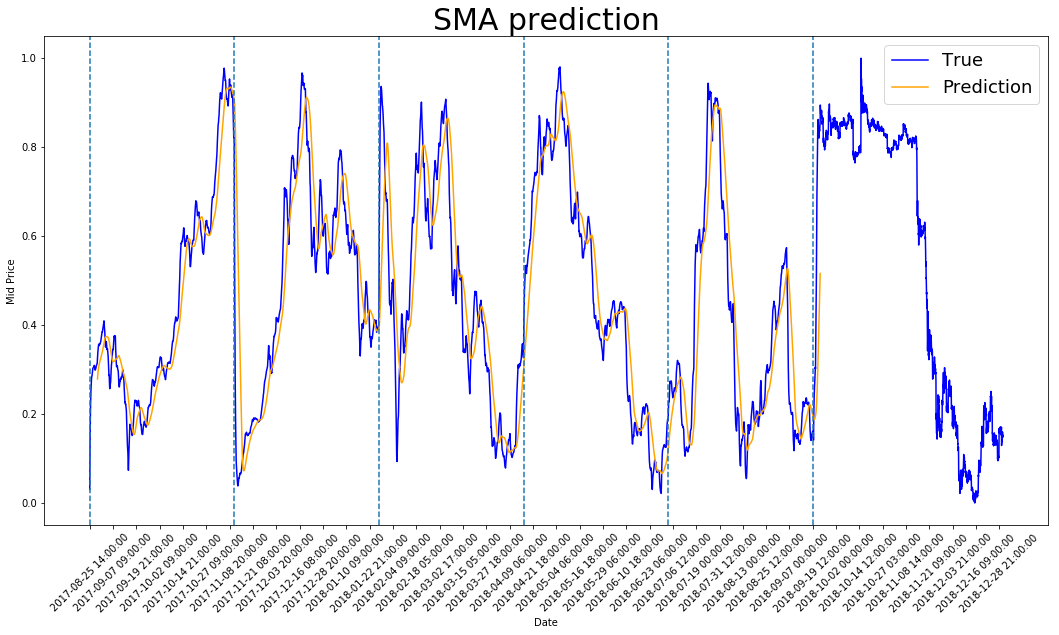

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),sma_predictions,color='orange',label='Prediction')
plt.xticks(range(0,data.shape[0],300),data['open_time'].loc[::300],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.title('SMA prediction', fontsize=30)
# Vlines showing the borders of scaling windows.
for di in range(0, round_size+smoothing_window_size, smoothing_window_size):
    plt.axvline(di, linestyle='--')
plt.show()

## EMA
What is Exponential Moving Average - EMA
An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.

Source: https://www.investopedia.com/terms/e/ema.asp

In [20]:
ema_predictions = []
ema_errors = []
running_mean = sma_predictions[0]
multiplier = 2 / (window_size + 1)

ema_predictions.append(running_mean)
for pred_idx in range(window_size+1,N):
    running_mean = running_mean + multiplier*(train_data[pred_idx-1] - running_mean)
    ema_predictions.append(running_mean)
    ema_errors.append((ema_predictions[-1]-train_data[pred_idx])**2)

print(f'MSE error for EMA averaging: {0.5*np.mean(ema_errors):.5f}')

MSE error for EMA averaging: 0.00406


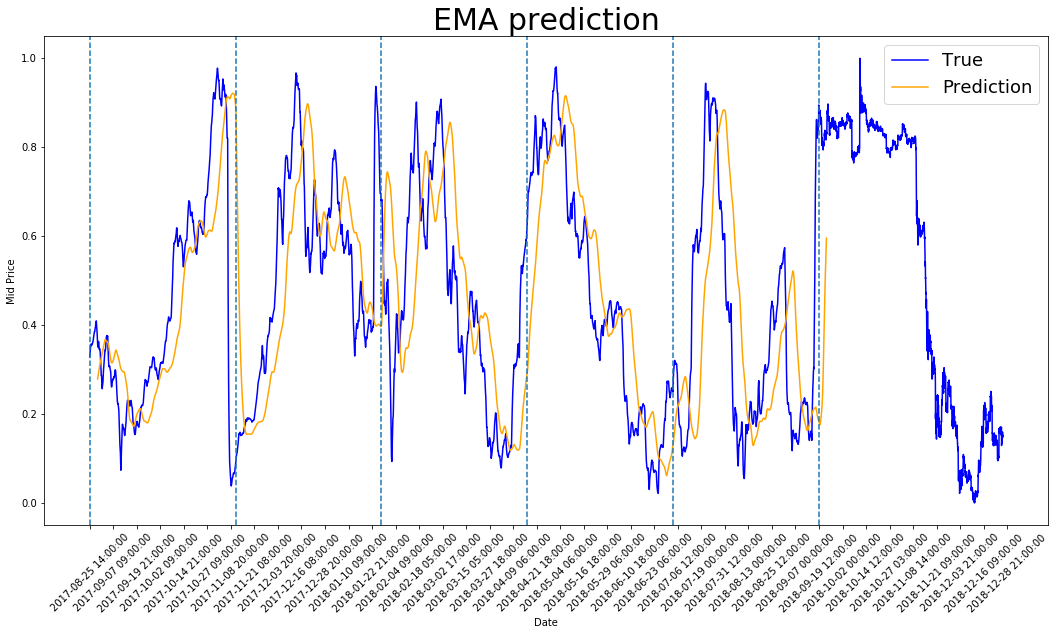

In [21]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]-window_size),all_mid_data[window_size:],color='b',label='True')
plt.plot(range(window_size,N),ema_predictions, color='orange', label='Prediction')
plt.xticks(range(0,data.shape[0],300),data['open_time'].loc[::300],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.title('EMA prediction', fontsize=30)
for di in range(0, round_size+smoothing_window_size, smoothing_window_size):
    plt.axvline(di, linestyle='--')
plt.show()

A significant amount of code below is based on the code from datacamp.com tutorial, which can be found here - [Link](https://www.datacamp.com/community/tutorials/lstm-python-stock-market). I have borrowed some of the code and fit it so that it would work with the Crypto Market.

In [22]:
class DataGeneratorSeq(object):
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

        
    def next_batch(self):
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
        return batch_data,batch_labels

    
    def unroll_batches(self):
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()    
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels

    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [23]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03050938 0.15698202 0.9171048  0.54749405 0.25065687]

	Output: [0.08297268 0.1329637  0.91372424 0.5552823  0.2521253 ]


Unrolled index 1
	Inputs:  [0.05818429 0.14452578 0.91372424 0.54943824 0.2521253 ]

	Output: [0.12855263 0.11173875 0.91160065 0.55247986 0.25355092]


Unrolled index 2
	Inputs:  [0.08297268 0.1329637  0.91160065 0.55061346 0.25355092]

	Output: [0.1480753  0.0932033  0.9071165  0.55777377 0.25593436]


Unrolled index 3
	Inputs:  [0.10648182 0.12259979 0.9071165  0.55247986 0.2541504 ]

	Output: [0.1480753  0.11173875 0.90249527 0.5588841  0.25593436]


Unrolled index 4
	Inputs:  [0.12855263 0.11173875 0.90249527 0.5552823  0.25476885]

	Output: [0.16608422 0.10056487 0.8948992  0.55777377 0.25853533]


In [24]:
import tensorflow as tf

In [25]:
D = 1 # Dimensionality of the data (in this case - price)
num_unrollings = 50 # Number of timesteps looking into future
batch_size = 500 # Number of samples in one batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack
n_layers = len(num_nodes) # Number of layers
dropout = 0.2 # dropout amount
tf.reset_default_graph() # Clearing the default graph stack

In [26]:
# Input data.
train_inputs, train_outputs = [],[]

# Generating train data for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name=f'train_inputs_{ui}'))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name =f'train_outputs_{ui}'))

In [27]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
    for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(lstm, 
                                                 input_keep_prob=1.0,
                                                 output_keep_prob=1.0-dropout, 
                                                 state_keep_prob=1.0-dropout)
                   for lstm in lstm_cells]

drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [28]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [29]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [30]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [31]:
test_len = int(len(test_data)/50)*50
train_len = int(len(train_data) / 50) *50
test_len, train_len

(2300, 9350)

In [32]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(train_len, train_len+test_len, 50).tolist()

# Number of times the model will be learned for each epoch.
train_counts = train_seq_length//batch_size

for ep in range(epochs):       

    # ========================= Training =====================================
    # Each epoch will consist of train_seq_
    
    for step in range(train_counts):
        u_data, u_labels = data_gen.unroll_batches()
        feed_dict = {}
        
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:
        average_loss = average_loss/(valid_summary*(train_counts))

        # The average loss
        if (ep+1) % valid_summary == 0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)
        average_loss = 0 # reset loss
        predictions_seq = []
        mse_test_loss_seq = []

        # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
              # Only calculate x_axis values in the first validation epoch
              x_axis=[]

            # Feed in the recent past behavior of stock prices
            # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}
            current_price = all_mid_data[w_i-1]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

            # Make predictions for this many steps
            # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):
                pred = session.run(sample_prediction,feed_dict=feed_dict)
                our_predictions.append(np.asscalar(pred))
                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)
                    
                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

            session.run(reset_sample_states)
            predictions_seq.append(np.array(our_predictions))
            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

        # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))

        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')


Initialized
Average loss at step 1: 2.348454
	Test MSE: 0.06520
	Finished Predictions
Average loss at step 2: 0.237898
	Test MSE: 0.00499
	Finished Predictions
Average loss at step 3: 0.117664
	Test MSE: 0.00510
	Finished Predictions
Average loss at step 4: 0.093106
	Test MSE: 0.00316
	Finished Predictions
Average loss at step 5: 0.080096
	Test MSE: 0.00299
	Finished Predictions
Average loss at step 6: 0.071456
	Test MSE: 0.00356
	Finished Predictions
Average loss at step 7: 0.065317
	Test MSE: 0.00314
	Finished Predictions
Average loss at step 8: 0.064401
	Decreasing learning rate by 0.5
	Test MSE: 0.00306
	Finished Predictions
Average loss at step 9: 0.061757
	Test MSE: 0.00253
	Finished Predictions
Average loss at step 10: 0.059449
	Test MSE: 0.00288
	Finished Predictions
Average loss at step 11: 0.058517
	Test MSE: 0.00307
	Finished Predictions
Average loss at step 12: 0.058047
	Decreasing learning rate by 0.5
	Test MSE: 0.00297
	Finished Predictions
Average loss at step 13: 0.0562

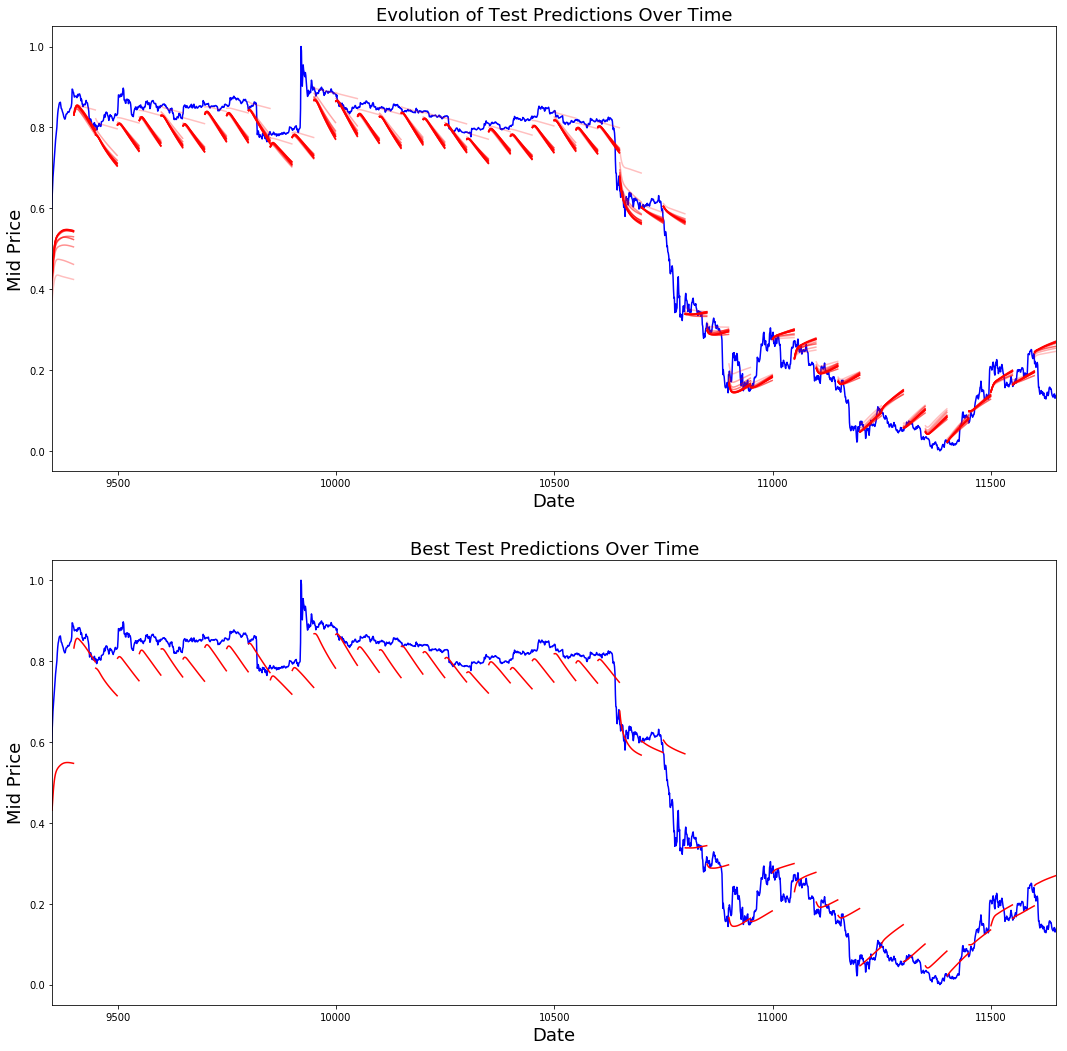

In [33]:
best_prediction_epoch = 27
plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(data.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha, 1.1, (1.0-start_alpha)/len(predictions_over_time[::4]))
for p_i,p in enumerate(predictions_over_time[4::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(train_len,train_len+test_len)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(data.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(train_len,train_len+test_len)
plt.show()